In [1]:
import numpy as np
import torch

In [2]:
from models import MPS, ComplexTensor

In [50]:
L=2
local_dim=2
bond_dim=2

In [51]:
psi = MPS(L=L, local_dim=local_dim, bond_dim=bond_dim)

In [52]:
fname_settings="datasets/settings_prod_state_spinup_L=%d.npy" %L
fname_samples="datasets/samples_prod_state_spinup_L=%d.npy"%L
# fname_settings = "settings_ghz_plus_all_discrete_bases_angles_L=%d.npy"%L
# fname_samples = "samples_ghz_plus_all_discrete_bases_angles_L=%d.npy"%L
samples = np.load(fname_samples)
samples_tr = torch.tensor((1-samples)/2).to(torch.long)
settings = np.load(fname_settings)

In [53]:
theta = torch.tensor(settings[...,0],dtype=torch.float32)
phi = torch.tensor(settings[...,1],dtype=torch.float32)

In [54]:
from qtools import pauli_exp

In [55]:
U = pauli_exp(theta, phi)
rotations_real = U.real
rotations_imag = U.imag

In [56]:
from torch.utils.data import TensorDataset, DataLoader

In [57]:
from models import MeasurementDataset, ComplexTensor

In [58]:
ds = MeasurementDataset(samples=samples_tr,rotations=U)

In [59]:
batch_size = 256
lr = .001

In [60]:
dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

In [61]:
losses = []

In [62]:
eps = 5

In [63]:
def sgd_step_at_site(mps, site_index, spin_config,
                         rotation=None, cutoff=1e-10, normalize='left', 
                        max_sv_to_keep=None):
    """Perform SGD step WRT two-site blob with left index at the site specified"""
    psi.gauge_to(site_index)
    #two-site blob matrix at the site
    A = psi.merge(i).numpy()
    #gradient of the log-prob WRT that complex matrix
    #note that A has to updated from the conjugate!
    g=psi.grad_twosite_logprob(i, spin_config,rotation=rotation).numpy().conj()
    #perform gradient descent step, insert back into MPS
    A = A - 2 * lr * g
    psi.set_sites_from_twosite(i, A,cutoff=cutoff,normalize=normalize, max_sv_to_keep=max_sv_to_keep)
   

In [64]:
nstep=1

In [65]:
max_sv = None
cutoff=1e-6

In [66]:
for ep in range(eps):
    for step, inputs in enumerate(dl):
        spinconfig = inputs['samples']
        rot = inputs['rotations']
        rotations = ComplexTensor(rot['real'], rot['imag'])
        for i in range(L-1):
            for __ in range(nstep):
                sgd_step_at_site(psi, i, spinconfig,
                                        rotation=rotations,cutoff=cutoff,normalize='left',max_sv_to_keep=max_sv)   
        for i in range(L-2, -1,-1):
            for __ in range(nstep):
                sgd_step_at_site(psi, i, spinconfig,
                                     rotation=rotations, cutoff=cutoff,normalize='right',max_sv_to_keep=max_sv)
        with torch.no_grad():
            losses.append(psi.nll_loss(spinconfig,rotation=rotations))
    print("finished epoch %d" % ep)

        

finished epoch 0
finished epoch 1
finished epoch 2
finished epoch 3
finished epoch 4


In [67]:
import matplotlib.pyplot as plt

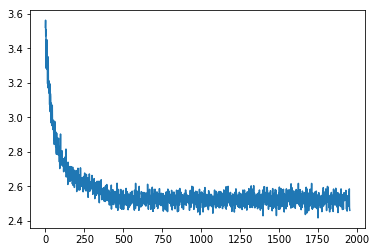

In [68]:
%matplotlib inline
plt.plot(losses)

In [69]:
print(psi.shape)

[(1, 2), (2, 4), (4, 2), (2, 1)]


In [70]:
from tools import generate_binary_space

In [71]:
basis = torch.tensor(generate_binary_space(L),dtype=torch.long)

In [72]:
with torch.no_grad():
    for i in range(len(basis)):
        print("{0} has probability {1:.4f}".format(basis[i], psi.prob_normalized(basis[i]).item()))

tensor([1, 1, 1, 1]) has probability 0.0001
tensor([1, 1, 1, 0]) has probability 0.0373
tensor([1, 1, 0, 1]) has probability 0.0377
tensor([1, 1, 0, 0]) has probability 0.0001
tensor([1, 0, 1, 1]) has probability 0.0382
tensor([1, 0, 1, 0]) has probability 0.3543
tensor([1, 0, 0, 1]) has probability 0.0000
tensor([1, 0, 0, 0]) has probability 0.0354
tensor([0, 1, 1, 1]) has probability 0.0372
tensor([0, 1, 1, 0]) has probability 0.0001
tensor([0, 1, 0, 1]) has probability 0.3507
tensor([0, 1, 0, 0]) has probability 0.0367
tensor([0, 0, 1, 1]) has probability 0.0000
tensor([0, 0, 1, 0]) has probability 0.0361
tensor([0, 0, 0, 1]) has probability 0.0361
tensor([0, 0, 0, 0]) has probability 0.0000
